In [42]:
#| echo: false
from pathlib import Path
import pandas as pd
import plotly.io as pio

pd.options.plotting.backend = 'plotly'
# Makes plotly render properly in Quarto. See https://quarto.org/docs/interactive/widgets/jupyter.html
pio.renderers.default = "plotly_mimetype+notebook_connected"  

DATA_DIR = Path('/Users/gurpreetjohl/workspace/python/alphadog/alphadog/data/csv_files/yfinance/')

tickers = ['BTCUSD', 'ETHUSD', 'SP500']

df_list = []
for ticker in tickers:
    tmp_df = pd.read_csv(DATA_DIR / f"{ticker}.csv").set_index('timestamp')['close']
    tmp_df = tmp_df[tmp_df.index >= '2018-01-01']
    df_list.append(tmp_df)

df = pd.concat(df_list, axis=1)
df.index = pd.to_datetime(df.index)
df.columns = tickers

# 1. Time Series Properties

## 1.1. Considerations for Time Series Data

Time series data has certain properties that make it different from other tabular or sequential data:

- **Ordering is important**: The order of data points is important so you need to be wary of information leakage. For example, unless you really know what you're doing and have a good reason, you probably shouldn't shuffle your train/test split.
- **Look-ahead bias**: Related to the above. We often want to forecast future data points, so we need to make sure our model is not inadvertently looking ahead.
- **Irregular sampling**: The data is not always at regular intervals. for example, tick-level financial data or heart beats in medical data.
- **Informative sampling**: The presence/timing of a sample contains information in and of itself. For example, more ticks in a short time window indicates more trading activity, or more heart beats in a time period indicates unusual activity. Resampling to a regular interval risks losing this information.


## 1.2. Trend
A time series may exhibit a trend over time. 
That is to say, it's rolling average is monotonically increasing/decreasing.

We can model this with a simple linear relationship w.r.t. time $t$:
$$
target = a t + b
$$

If the trend is non-linear, we can transform the time variable so we can still apply linear models.
For example, if we think the trend is quadratic with time, we can pass $t$ and $t^2$ as independent variables to a linear model:
$$
target = a t^2 + b t + c
$$

We may want to split the **trend and residual components** of the data and model them separately.
If the residuals are stations (more on this later) then there are more models that would be applicable.

A **moving average** term can be useful to eyeball changes in trend.

In [43]:
plot_ma_df = df[['BTCUSD']].copy()
plot_ma_df['100_day_MA'] = plot_ma_df['BTCUSD'].rolling(100).mean()

plot_ma_df.plot()

## 1.3. Seasonality

Seasonality is when there are regular, periodic changes in the mean of a time series.
They often happen at "human-interpretable" intervals, e.g. daily, weekly, monthly, etc.

A **seasonal plot** can help identify such seasonality.
If we suspect day-of-week seasonality, we can plot the day of week vs target value to see if there is a common behaviour.

This time series doesn't actually exhibit any strong seasonality, but let's see how we'd check.

In [59]:
plot_seasonal_df = df[['BTCUSD']].copy()
plot_seasonal_df['day_of_week'] = plot_seasonal_df.index.dayofweek

plot_seasonal_df.tail(50).set_index('day_of_week').plot()

**Seasonal indicators** are binary features that represent the seasonality level of interest.

For example, if we believed there was weekly seasonality, we could one-hot encode each day of the week as a feature.

In [62]:
plot_seasonal_df['Monday'] = (plot_seasonal_df['day_of_week'] == 0) * 1.
plot_seasonal_df['Tuesday'] = (plot_seasonal_df['day_of_week'] == 1) * 1.
plot_seasonal_df['Wednesday'] = (plot_seasonal_df['day_of_week'] == 2) * 1.
plot_seasonal_df['Thursday'] = (plot_seasonal_df['day_of_week'] == 3) * 1.
plot_seasonal_df['Friday'] = (plot_seasonal_df['day_of_week'] == 4) * 1.
plot_seasonal_df['Saturday'] = (plot_seasonal_df['day_of_week'] == 5) * 1.

plot_seasonal_df

,BTCUSD,day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
timestamp,,,,,,,,
2018-01-01,13657.200195,0,1.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,14982.099609,1,0.0,1.0,0.0,0.0,0.0,0.0
2018-01-03,15201.000000,2,0.0,0.0,1.0,0.0,0.0,0.0
2018-01-04,15599.200195,3,0.0,0.0,0.0,1.0,0.0,0.0
2018-01-05,17429.500000,4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2023-07-05,30514.166016,2,0.0,0.0,1.0,0.0,0.0,0.0
2023-07-06,29909.337891,3,0.0,0.0,0.0,1.0,0.0,0.0
2023-07-07,30342.265625,4,0.0,0.0,0.0,0.0,1.0,0.0


We can **decompose** a timeseries into `trend + seasonal + residual` components.

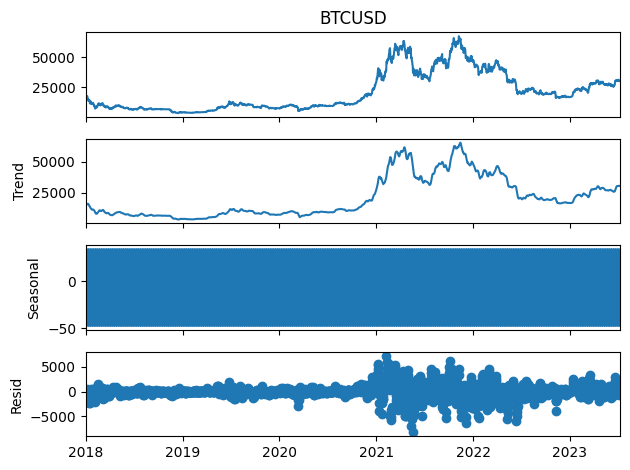

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['BTCUSD'], model='additive', filt=None, period=None, two_sided=False, extrapolate_trend=0)
fig = decomp.plot()

**Fourier analysis** can be useful in determining frequencies of seasonality.
More on this later.

In brief, we can plot the **periodogram** to determine the strength of different frequencies.

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

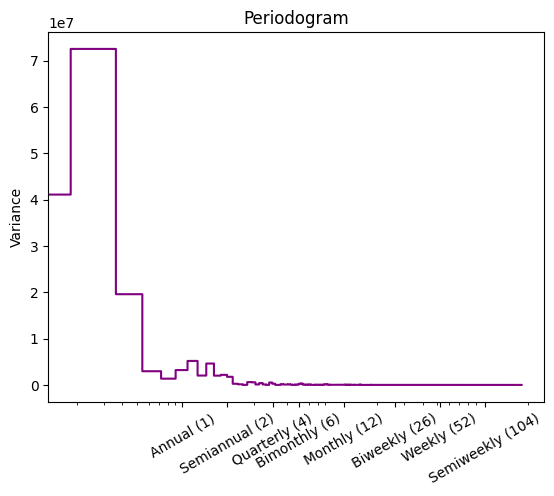

In [65]:
# From https://www.kaggle.com/code/ryanholbrook/seasonality
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


plot_periodogram(df['BTCUSD'])

## 1.4. Stationarity

> A stationary time series is one whose properties do not depend on the time at which the series is observed 

From [Forecasting: Principles and Practice](https://otexts.com/fpp2/stationarity.html)

In other words, the mean and variance do not change over time.

In the context of financial time series, it is often the case that *price* is non-stationary, but *returns* (the lag-1 difference) is stationary.

The **Augmented Dickey-Fuller** test provides a test statistic to quantify stationarity.
<!-- TODO GJ: learn more about Dickey-Fuller -->


Using the BTCUSD time series as an example, the price series is definitely not stationary. We can see this from a plot, but the ADF test corroborates this with a p-value of 0.58.

In [79]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['BTCUSD'])
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
}

adf_results


{'ADF Statistic': -1.4058608330365159,
 'p-value': 0.5794631585252685,
 'Critical Values': {'1%': -3.4336386745240652,
  '5%': -2.8629927557359443,
  '10%': -2.5675433856598793}}

Next we take the differences.
This is stationary, with a tiny p-value.

In [80]:
btc_rets = df['BTCUSD'].diff().dropna()

adf_test = adfuller(btc_rets)
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
}

adf_results

{'ADF Statistic': -7.742323245600769,
 'p-value': 1.0538877703747789e-11,
 'Critical Values': {'1%': -3.433643643742798,
  '5%': -2.862994949652858,
  '10%': -2.5675445538118042}}

<!-- ## 1.5. Correlations and Autocorrelations
### Correlation
### Autocorrelation
Serial dependence https://www.kaggle.com/code/ryanholbrook/time-series-as-features
Lag plots (same link as above)

### Partial Autocorrelation -->

<!-- #  2. Feature Engineering
## Nulls


## Lags


## Time step


## Regime Change
- Split into different models per regime
- Indicator variable for regime
- Some models explicitly model this, e.g. Hidden Markov Models


## Hybrid Models
https://www.kaggle.com/code/ryanholbrook/hybrid-models

Model the time series as components
`series = trend + seasons + cycles + error`


# 3. Forecasting
https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning


# 4. Fourier Analysis
https://www.kaggle.com/code/ryanholbrook/seasonality

Periodogram
FFT


# 5. Classical Statistical Models

## Linear Models
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

## AR

## MA


## ARIMA


## VAR


# 6. Traditional ML Models

## Random Forests


## Gradient Boosted Trees

##


# 7. Deep Learning

## RNNS, LSTMs, GRUs

## Transformers

## Foundational Models

 -->


# References

- https://www.kaggle.com/learn/time-series
- https://www.kaggle.com/code/ryanholbrook/trend
- https://otexts.com/fpp2/stationarity.html